In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from fredapi import Fred
from dateutil import parser
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
import statsmodels.api as sm

fred = Fred(api_key='') #Add Api key 

# memory management
import gc

import warnings
warnings.filterwarnings('ignore')

# Forecasting Equity Market Trends Based on Economic Indicators

In [2]:
# List of Yahoo Finance tickers and corresponding FRED series IDs
tickers = {
    'sp500': '^GSPC', # sp 500 predicted variable
    't_bill_10y': '^TNX',     # Monetary Supply
    'crude_oil' : 'CL=F', # Crude Oil
}

fred_series = {
    # General Macroeconomic
    'cpi' : 'CPIAUCSL',
    'ipi' : 'INDPRO',
    # Labor Market
    'unemployment_rate' : 'UNRATE',
    'unemployment_level' :'UNEMPLOY',
    'employment_level' : 'CE16OV',
    'labor_force_rate' : 'CIVPART',
    
    # Real Estate
    'house_start' : 'HOUST',
    'house_permit' : 'PERMIT',
    
    # Credit Market
    'interbank_interet_rates': 'IR3TIB01USM156N',
    't_bill_3m' :'TB3MS',
    'comercial_industrial_loans' : 'BUSLOANS',
    'bank_prime_loan_rate' : 'MPRIME',
    'bank_credit' : 'LOANINV',
    
    # Monetary Supply
    'm1' : 'M1SL',
    'm2' : 'M2SL',
    'fund_rate' : 'FEDFUNDS',
    'currency_circulation' : 'CURRCIR',
    
    # Consumer Financial Behavior
    'personal_saving_rate' : 'PSAVERT',
    'pce' : 'PCE',
    'real_disposable_personal_income' : 'DSPIC96',
    'personal_saving' : 'PMSAVE',
    'demand_deposits' : 'DEMDEPSL',
    
    # Commodity market
    'vehicle_sales' : 'TOTALSA'
}

# Historical range
start_date = "1990-01-01"
end_date = "2023-12-31"

# Fetch Yahoo Finance data
yf_data = pd.DataFrame()
for name, ticker in tickers.items():
    cleab_yf_df = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    yf_data[name] = cleab_yf_df

# Fetch FRED data
fred_data = pd.DataFrame()
for name, series_id in fred_series.items():
    clean_fred_df = fred.get_series(series_id, observation_start=start_date)
    clean_fred_df = clean_fred_df.resample('M').last()
    fred_data[name] = clean_fred_df

raw_data  = pd.concat([yf_data, fred_data], axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:

# Forward fill to handle missing values, if appropriate
combined_data = raw_data.copy()
combined_data = combined_data.ffill()

# Assuming 21 trading days in a month, calculate the price 3 months later
forward_3m_price = combined_data['sp500'].shift(-61)

# Calculate the percentage change to get the forward 3-month return
combined_data['forward_3m_return'] = (forward_3m_price - combined_data['sp500']) / combined_data['sp500']

# Convert to binary: 1 if the return is positive, 0 if negative or no change
combined_data['price_trend'] = (combined_data['forward_3m_return'] > 0).astype(int)

# Drop the NA values that result from the shift operation
# Also, drop 'sp500' and 'forward_3m_return' as they are no longer needed
combined_data.dropna(inplace=True)
combined_data.drop(columns=['sp500', 'forward_3m_return'], inplace=True)


combined_data

,t_bill_10y,crude_oil,cpi,ipi,unemployment_rate,unemployment_level,employment_level,labor_force_rate,house_start,house_permit,...,m2,fund_rate,currency_circulation,personal_saving_rate,pce,real_disposable_personal_income,personal_saving,demand_deposits,vehicle_sales,price_trend
2000-08-23,5.725,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-24,5.716,31.629999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-25,5.721,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-28,5.766,32.869999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-29,5.808,32.720001,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,4.573,90.790001,306.269,103.2411,3.8,6340.0,161500.0,62.8,1305.0,1541.0,...,20825.5,5.33,2330.824,4.4,18651.6,16814.6,895.3,4899.7,15.838,1
2023-09-30,4.573,90.790001,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1
2023-10-02,4.683,88.820000,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1
2023-10-03,4.802,89.230003,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1


In [4]:
# Summary Statistics
summary_statistics = combined_data.describe()
summary_statistics

,t_bill_10y,crude_oil,cpi,ipi,unemployment_rate,unemployment_level,employment_level,labor_force_rate,house_start,house_permit,...,m2,fund_rate,currency_circulation,personal_saving_rate,pce,real_disposable_personal_income,personal_saving,demand_deposits,vehicle_sales,price_trend
count,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,...,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000,5897.000000
mean,3.137668,63.971670,226.670045,97.065172,5.838274,9027.332033,145970.677972,64.267594,1293.236052,1351.035781,...,10969.635425,1.629542,1226.506647,5.790826,11394.101001,13263.988333,780.197575,1253.325623,15.904924,0.656775
std,1.232010,25.560219,32.943016,4.961709,1.973158,3032.164535,7258.276371,1.740629,445.000888,460.252770,...,4903.420405,1.814147,525.242651,3.317643,3021.194030,2044.374557,678.982303,1354.850699,2.259407,0.474826
min,0.499000,-37.630001,172.700000,84.597900,3.400000,5534.000000,133185.000000,60.100000,478.000000,513.000000,...,4789.400000,0.050000,569.313000,1.400000,6768.500000,10035.900000,128.900000,296.200000,8.834000,0.000000
25%,2.135000,44.630001,201.300000,92.862100,4.400000,6854.000000,139492.000000,62.800000,973.000000,1014.000000,...,6806.900000,0.130000,793.601000,4.400000,9231.800000,11744.400000,428.300000,330.600000,14.769000,0.000000
50%,2.990000,61.680000,228.329000,98.432200,5.400000,8003.000000,144778.000000,63.800000,1273.000000,1336.000000,...,9785.700000,1.010000,1080.197000,5.400000,10987.200000,12852.100000,670.500000,779.100000,16.661000,1.000000
75%,4.172000,83.680000,247.284000,101.435500,6.700000,10538.000000,151761.000000,66.100000,1625.000000,1695.000000,...,13799.900000,2.400000,1592.131000,6.300000,13417.300000,14771.100000,873.600000,1471.800000,17.514000,1.000000
max,5.892000,145.289993,307.481000,104.118100,14.800000,23090.000000,161550.000000,67.200000,2273.000000,2263.000000,...,21703.600000,6.540000,2342.699000,32.000000,18791.500000,20422.600000,5976.400000,5181.200000,22.055000,1.000000


In [5]:
combined_data

,t_bill_10y,crude_oil,cpi,ipi,unemployment_rate,unemployment_level,employment_level,labor_force_rate,house_start,house_permit,...,m2,fund_rate,currency_circulation,personal_saving_rate,pce,real_disposable_personal_income,personal_saving,demand_deposits,vehicle_sales,price_trend
2000-08-23,5.725,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-24,5.716,31.629999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-25,5.721,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-28,5.766,32.869999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-29,5.808,32.720001,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,4.573,90.790001,306.269,103.2411,3.8,6340.0,161500.0,62.8,1305.0,1541.0,...,20825.5,5.33,2330.824,4.4,18651.6,16814.6,895.3,4899.7,15.838,1
2023-09-30,4.573,90.790001,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1
2023-10-02,4.683,88.820000,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1
2023-10-03,4.802,89.230003,307.481,103.3346,3.8,6347.0,161550.0,62.8,1356.0,1471.0,...,20755.3,5.33,2328.907,3.8,18791.5,16804.5,777.2,4924.4,16.160,1


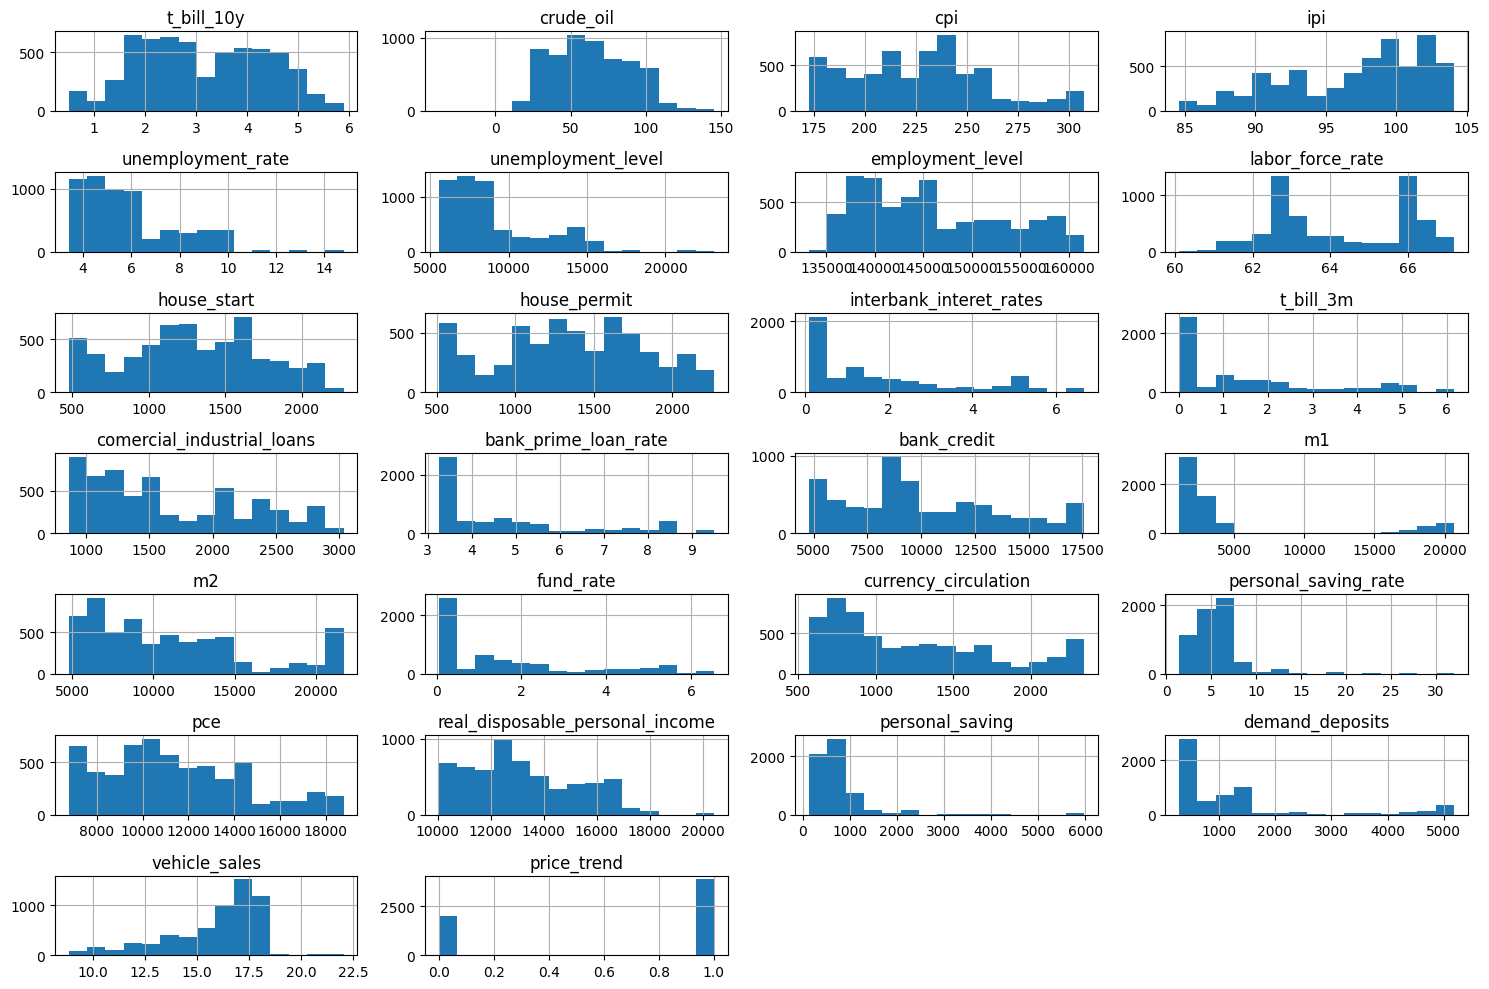

In [6]:
# Distribution Analysis - Histograms for each variable
combined_data.hist(bins=15, figsize=(15, 10), layout=(7, 4))
plt.tight_layout()
plt.show()

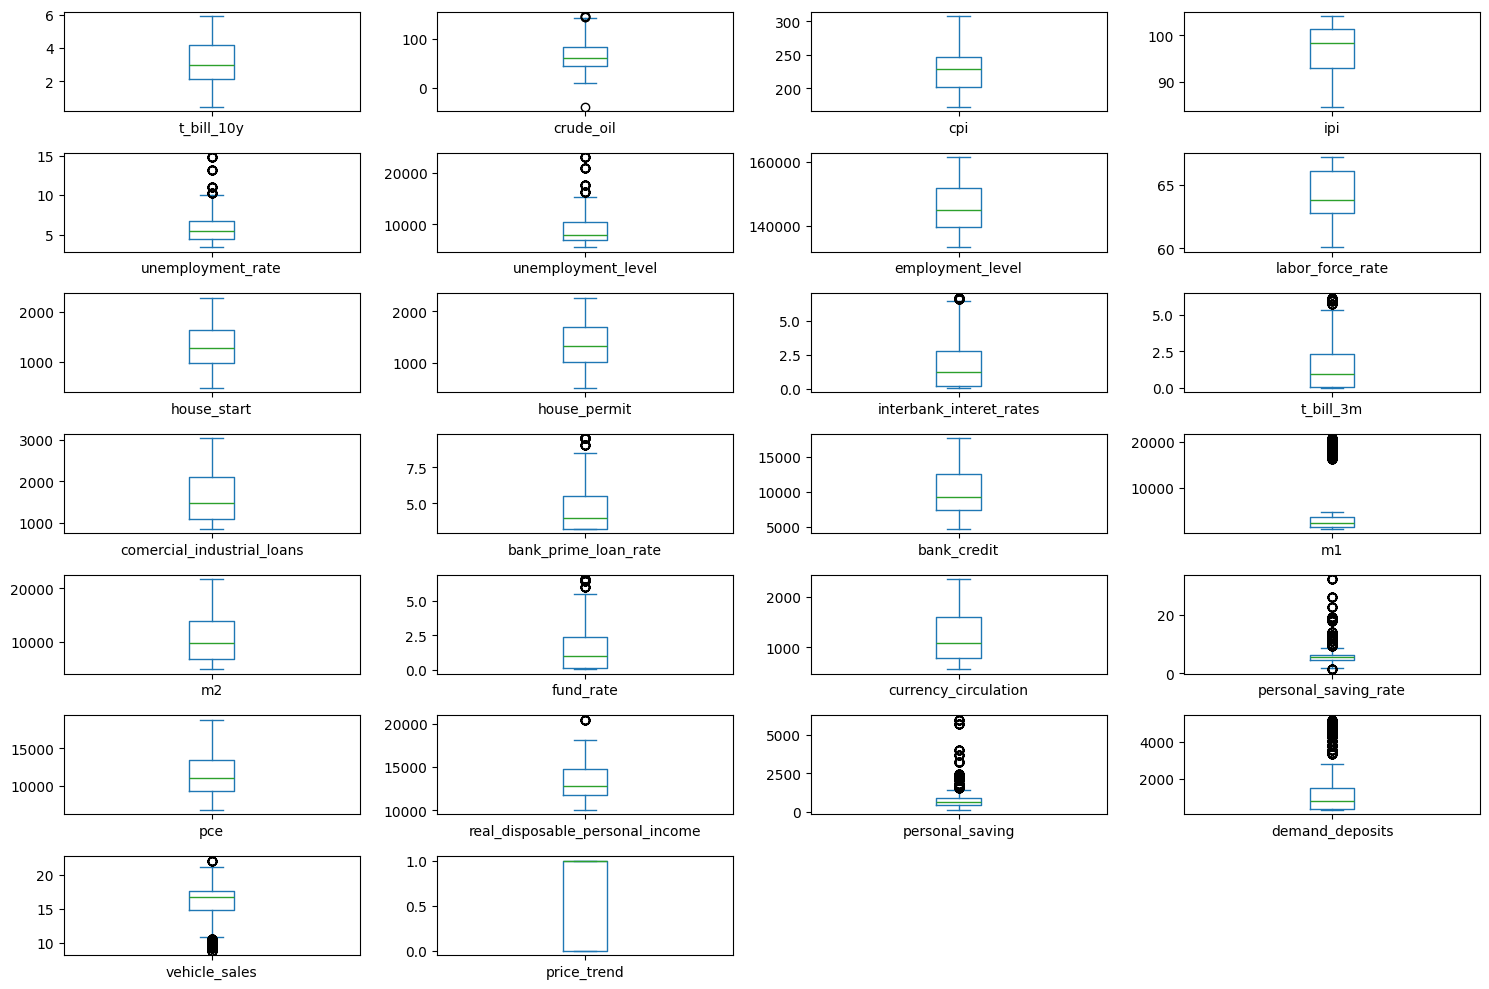

In [7]:
# Boxplot for each variable to identify outliers
combined_data.plot(kind='box', subplots=True, layout=(7, 4), figsize=(15, 10))
plt.tight_layout()
plt.show()

In [8]:
# Check the strength of relationship between features and target and remove weak relationship
from scipy.stats import pointbiserialr
import pandas as pd

def point_biserial_correlation(data, numerical_columns, target_column):
    results = []

    for column in numerical_columns:
        coef, p_val = pointbiserialr(data[column], data[target_column])
        results.append([column, coef, p_val])

    results_df = pd.DataFrame(results, columns=['Feature', 'Point-Biserial Coefficient', 'P-Value'])
    return results_df

# Assuming 'combined_data' is your DataFrame
# Calculate Point-Biserial Correlation Coefficient for each numerical feature against the target
numerical_columns = list(combined_data.drop('price_trend', axis=1).columns)
point_biserial_results_df = point_biserial_correlation(combined_data, numerical_columns, 'price_trend')

# Display sorted results
sorted_results_df = round(point_biserial_results_df.sort_values(by='Point-Biserial Coefficient', ascending=False), 1)
print(sorted_results_df)


                            Feature  Point-Biserial Coefficient  P-Value
22                  personal_saving                         0.2      0.0
19             personal_saving_rate                         0.2      0.0
5                unemployment_level                         0.2      0.0
21  real_disposable_personal_income                         0.2      0.0
4                 unemployment_rate                         0.2      0.0
2                               cpi                         0.1      0.0
14                      bank_credit                         0.1      0.0
18             currency_circulation                         0.1      0.0
20                              pce                         0.1      0.0
16                               m2                         0.1      0.0
12       comercial_industrial_loans                         0.1      0.0
6                  employment_level                         0.1      0.0
23                  demand_deposits                

In [9]:
# Define the threshold for relevance and remove weak relationship
threshold = 0.1

# Filter the features based on the threshold
relevant_features = sorted_results_df[sorted_results_df['Point-Biserial Coefficient'] >= threshold]['Feature'].tolist()
relevant_features

['personal_saving',
 'personal_saving_rate',
 'unemployment_level',
 'real_disposable_personal_income',
 'unemployment_rate',
 'cpi',
 'bank_credit',
 'currency_circulation',
 'pce',
 'm2',
 'comercial_industrial_loans',
 'employment_level',
 'demand_deposits']

In [10]:
from sklearn.model_selection import train_test_split
# numerical_relevant_features
features_data = combined_data[relevant_features + ['price_trend']]

# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(features_data.drop('price_trend', axis=1),
                                                    features_data['price_trend'], 
                                                    test_size=0.3, 
                                                    random_state=42)

# Displaying the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4127, 13), (1770, 13), (4127,), (1770,))

In [11]:
# Handling imbalanced data

y_train.value_counts()

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote.values.ravel())

# Predicting on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluating the model
accuracy_log_reg = "Accuracy of Logistic Regression: {:.2f}%".format(accuracy_score(y_test, y_pred_log_reg) * 100)
report_log_reg = classification_report(y_test, y_pred_log_reg, output_dict=True)

# Displaying the accuracy and the classification report
print(accuracy_log_reg)
print("Classification Report:")
print(pd.DataFrame(report_log_reg).transpose())

Accuracy of Logistic Regression: 61.75%
Classification Report:
              precision    recall  f1-score      support
0              0.456180  0.677796  0.545332   599.000000
1              0.780682  0.586678  0.669917  1171.000000
accuracy       0.617514  0.617514  0.617514     0.617514
macro avg      0.618431  0.632237  0.607625  1770.000000
weighted avg   0.670864  0.617514  0.627755  1770.000000


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the model with the SMOTE-resampled training data
svm_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluating the model
accuracy_svm = "Accuracy of SVM: {:.2f}%".format(accuracy_score(y_test, y_pred_svm) * 100)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Displaying the accuracy and the classification report
print(accuracy_svm)
print("Classification Report:")
print(pd.DataFrame(report_svm).transpose())


Accuracy of SVM: 63.39%
Classification Report:
              precision    recall  f1-score      support
0              0.460800  0.480801  0.470588   599.000000
1              0.728384  0.712212  0.720207  1171.000000
accuracy       0.633898  0.633898  0.633898     0.633898
macro avg      0.594592  0.596507  0.595398  1770.000000
weighted avg   0.637829  0.633898  0.635732  1770.000000


In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the model with the SMOTE-resampled training data
nb_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Evaluating the model
accuracy_nb = "Accuracy of Naive Bayes: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)

# Displaying the accuracy and the classification report
print(accuracy_nb)
print("Classification Report:")
print(pd.DataFrame(report_nb).transpose())


Accuracy of Naive Bayes: 53.22%
Classification Report:
              precision    recall  f1-score      support
0              0.400348  0.767947  0.526316   599.000000
1              0.776167  0.411614  0.537946  1171.000000
accuracy       0.532203  0.532203  0.532203     0.532203
macro avg      0.588258  0.589780  0.532131  1770.000000
weighted avg   0.648983  0.532203  0.534010  1770.000000


In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the model with the SMOTE-resampled training data
gb_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Evaluating the model
accuracy_gb = "Accuracy of Gradient Boosting: {:.2f}%".format(accuracy_score(y_test, y_pred_gb) * 100)
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)

# Displaying the accuracy and the classification report
print(accuracy_gb)
print("Classification Report:")
print(pd.DataFrame(report_gb).transpose())


Accuracy of Gradient Boosting: 87.18%
Classification Report:
              precision    recall  f1-score      support
0              0.770349  0.884808  0.823621   599.000000
1              0.936229  0.865073  0.899245  1171.000000
accuracy       0.871751  0.871751  0.871751     0.871751
macro avg      0.853289  0.874940  0.861433  1770.000000
weighted avg   0.880092  0.871751  0.873653  1770.000000


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluating the model
accuracy_rf = "Accuracy of Random Forest: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Displaying the accuracy and the classification report
print(accuracy_rf)
print("Random Forest Classifier Classification Report:")
print(pd.DataFrame(report_rf).transpose())


Accuracy of Random Forest: 90.62%
Random Forest Classifier Classification Report:
              precision    recall  f1-score      support
0              0.827534  0.913189  0.868254   599.000000
1              0.953111  0.902647  0.927193  1171.000000
accuracy       0.906215  0.906215  0.906215     0.906215
macro avg      0.890322  0.907918  0.897723  1770.000000
weighted avg   0.910613  0.906215  0.907247  1770.000000
